## ARIMA Sample
### source : https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

### LIBRARY IMPORT SECTION 

In [1]:
#Library import section
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#dicky fullter test 
from statsmodels.tsa.stattools import adfuller

#seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

#acf  and pacf plot
from statsmodels.tsa.stattools import acf, pacf

#arima
from statsmodels.tsa.arima_model import ARIMA

#markdown display
from IPython.display import display, Markdown

### FUNCTION DEFENITION

In [2]:
def test_stationary(dataset, timeseries_column):
    #determing rolling statistics 
    rolling_mean = pd.Series(dataset[timeseries_column]).rolling(window=12).mean()
    rolling_std = pd.Series(dataset[timeseries_column]).rolling(window=12).std()
    
    display(Markdown('STATIONARY TEST RESULT'))

    #plot rolling statistics
    orig = plt.plot(dataset[timeseries_column], color='blue', label='origional')
    mean = plt.plot(rolling_mean, color='red', label='rolling mean')
    std = plt.plot(rolling_std, color='black', label='rolling std')
    plt.title('rolling mean & standard deviation')
    plt.legend(loc='best')
    plt.show()
    
    #dicky fullter test
    print('dicky fullter test result:')
    dicky_fullter_test = adfuller(dataset[timeseries_column], autolag='AIC')
    
    dicky_fullter_result = pd.Series(dicky_fullter_test[0:4], index=['test statistic', 'p-value', '#lags used', 'number of observation'])
    
    for key, value in dicky_fullter_test[4].items():
        dicky_fullter_result['critical value (%s)'%key] = value
    
    return dicky_fullter_result

In [3]:
def apply_transformation_and_plot_dataset(dataset, transformation_type):
    dataset_transformed = None
    if (transformation_type == 'log'):
        dataset_transformed = np.log(dataset)
    # add for square root, cube root, etc
    else: 
        raise Exception('Unknown transformation type')
    
    if (dataset_transformed is not None):
        dataset_transformed.plot(color='orange')
    
    return dataset_transformed

In [4]:
def apply_rolling_transformation_and_plot_dataset(dataset, timeseries_column_name, rolling_transformation_type):
    dataset_transformed = None
    rolling_transformataion_name = None
    
    if (rolling_transformation_type == 'mean'):
        dataset_transformed = pd.Series(dataset[timeseries_column_name]).rolling(window=12).mean()
        rolling_transformataion_name = 'rolling mean'
    else:
        raise Exception('unknown rolling transformation type.')
    
    if (dataset_transformed is not None):
        plt.plot(dataset, color='blue',label='original')
        plt.plot(dataset_transformed, color='red',label=rolling_transformataion_name)
        plt.legend(loc='best')
        plt.show()
        

    #convert the result into Dataframe
    dataset_transformed = pd.DataFrame(dataset_transformed)
    return dataset_transformed

In [5]:
def decompose_and_plot(dataset, timeseries_column_name):
    decomposition = seasonal_decompose(dataset)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    #original
    plt.subplot(411)
    plt.plot(dataset, label='original', color='blue')
    plt.legend(loc='best')
    
    #trend
    plt.subplot(412)
    plt.plot(trend, label='trend', color='green')
    plt.legend(loc='best')
    
    #seasonality
    plt.subplot(413)
    plt.plot(seasonal, label='seasonality',color='lightgreen')
    plt.legend(loc='best')
    
    #residual
    plt.subplot(414)
    plt.plot(residual, label='residuals', color='yellow')
    plt.legend(loc='best')
    
    plt.tight_layout()
    
    result = pd.DataFrame()
    result['trend'] = trend
    result['seasonal'] = seasonal
    result['residual'] = residual
    
    return result


In [6]:
def plot_acf_and_pacf(dataset):
    lag_acf = acf(dataset, nlags=20)
    lag_pacf= pacf(dataset, nlags=20, method='ols')
    
    #plot acf
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(dataset)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

In [67]:
def create_arima_and_plot_result_old(dataset, p,d, q):
    model = ARIMA(dataset, order=(p, d, q))
    model_fit = model.fit(disp=-1)
    plt.plot(dataset)
    plt.plot(model_fit.fittedvalues, color='red')
    fittedvalues_dataframe = pd.DataFrame(model_fit.fittedvalues)
    fitted_values_dataframe.columns = ['Passengers']
    fitted_values_dataframe.dropna(inplace=True)
    difference_dataframe = fitted_values_dataframe - dataset
    difference_dataframe.dropna(inplace=True)
    rss = sum(difference_dataframe.values ** 2)
    print('*********rss************',rss.values)
    plt.title('RSS %4f'%rss.values)
    plt.show()
    return model_fit

In [73]:
def create_arima_and_plot_result(training_dataset, transformed_data_set, p,d, q):
    model = ARIMA(training_dataset, order=(p, d, q))
    model_fit = model.fit(disp=-1)
    plt.plot(transformed_data_set)
    plt.plot(model_fit.fittedvalues, color='red')
    fitted_values = pd.DataFrame(model_fit.fittedvalues,columns=['Passengers'])
    error_values = fitted_values - transformed_data_set
    rss = np.sum(error_values.dropna() ** 2)
    print('*********rss************ : ',rss.values)
    plt.title('RSS %4f'%rss.values)
    plt.show()
    return model_fit

In [8]:
#load the dataset
def load_airline_passengers_dataset():
    #date parse logic - lambda function to read the string Y-m date and return datetime type.
    # date_parser: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’.
    dateparse = lambda date : pd.datetime.strptime(date, '%Y-%m')
    dataset = pd.read_csv('..\data\passengers\international-airline-passengers.csv',sep=';',index_col='Month', 
                          parse_dates=['Month'], date_parser=dateparse)
    
    return dataset

### EXPERIMENT AREA

In [9]:
dataset = load_airline_passengers_dataset()

C:\Users\henci\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


In [10]:
dataset.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


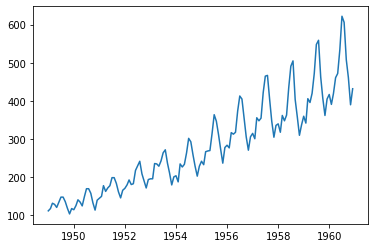

In [11]:
#plot the data
plt.plot(dataset)

#### we notice a increasing trend above.

STATIONARY TEST RESULT

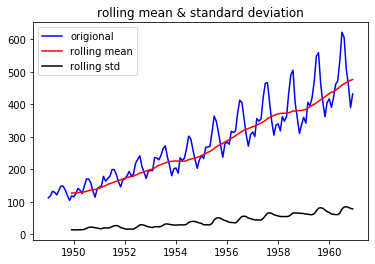

dicky fullter test result:


test statistic             0.815369
p-value                    0.991880
#lags used                13.000000
number of observation    130.000000
critical value (1%)       -3.481682
critical value (5%)       -2.884042
critical value (10%)      -2.578770
dtype: float64

In [12]:
test_stationary(dataset, 'Passengers')

In [13]:
#Test stationary
dataset_log = np.log(dataset)

In [14]:

dataset_log.head()

,Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


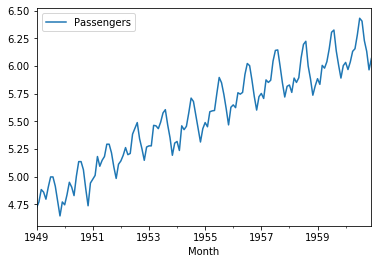

In [15]:
dataset_log.plot()

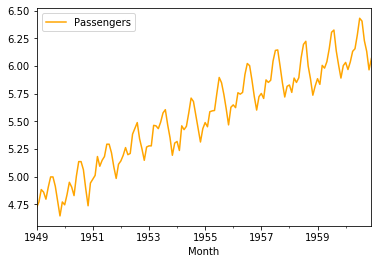

In [16]:
#approach 1 -taking log
dataset_log = apply_transformation_and_plot_dataset(dataset, 'log')

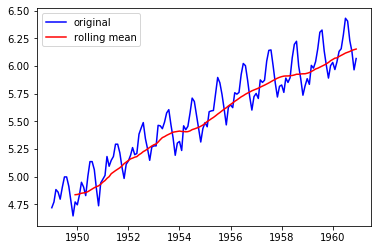

In [17]:
#apply rolling mean and plot
dataset_rolling_mean = apply_rolling_transformation_and_plot_dataset(dataset_log, 'Passengers', 'mean')


In [18]:
#find difference beween log and rolling_mean
dataset_log_moving_average_difference = dataset_log - dataset_rolling_mean


In [19]:
#drop the na values
dataset_log_moving_average_difference.dropna(inplace=True)

STATIONARY TEST RESULT

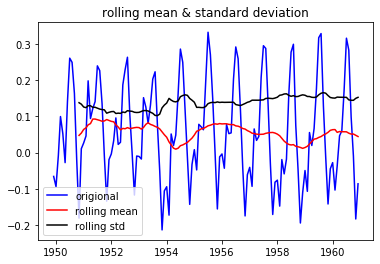

dicky fullter test result:


test statistic            -3.162908
p-value                    0.022235
#lags used                13.000000
number of observation    119.000000
critical value (1%)       -3.486535
critical value (5%)       -2.886151
critical value (10%)      -2.579896
dtype: float64

In [20]:
test_stationary(dataset_log_moving_average_difference, 'Passengers')
#dataset_log
#dataset_rolling_mean
#dataset_log_moving_average_difference
#dataset_log_moving_average_difference.head(15)

In [21]:
#approach 2 - taking exponentially weighted moving average
exponentially_weighted_moving_average = pd.DataFrame.ewm(dataset_log, halflife=12).mean()

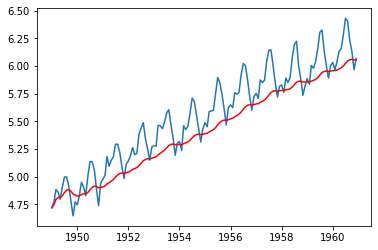

In [22]:
#exponentially_weighted_moving_average
plt.plot(dataset_log)
plt.plot(exponentially_weighted_moving_average, color='red')

In [23]:
#take difference
exp_weighted_average_difference = dataset_log - exponentially_weighted_moving_average

In [24]:
exp_weighted_average_difference.head()

,Passengers
Month,
1949-01-01,0.000000
1949-02-01,0.025339
1949-03-01,0.088967
1949-04-01,0.048028
1949-05-01,-0.012415


STATIONARY TEST RESULT

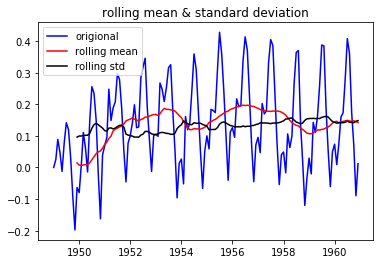

dicky fullter test result:


test statistic            -3.601262
p-value                    0.005737
#lags used                13.000000
number of observation    130.000000
critical value (1%)       -3.481682
critical value (5%)       -2.884042
critical value (10%)      -2.578770
dtype: float64

In [25]:
test_stationary(exp_weighted_average_difference,'Passengers')

In [26]:
#Elimnate trend and stationary
dataset_log_shift_difference = dataset_log - dataset_log.shift()

In [27]:
dataset_log_shift_difference.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022


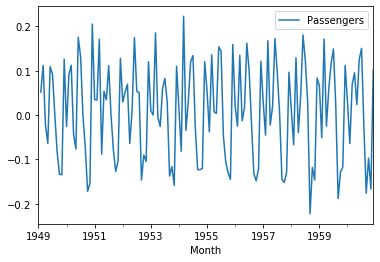

In [28]:
dataset_log_shift_difference.plot()

STATIONARY TEST RESULT

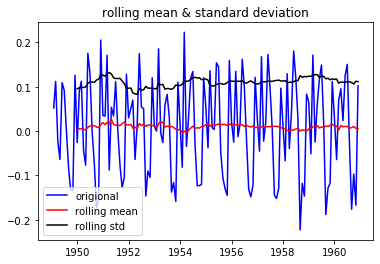

dicky fullter test result:


test statistic            -2.717131
p-value                    0.071121
#lags used                14.000000
number of observation    128.000000
critical value (1%)       -3.482501
critical value (5%)       -2.884398
critical value (10%)      -2.578960
dtype: float64

In [29]:
#remove na
dataset_log_shift_difference.dropna(inplace=True)
test_stationary(dataset_log_shift_difference,'Passengers')

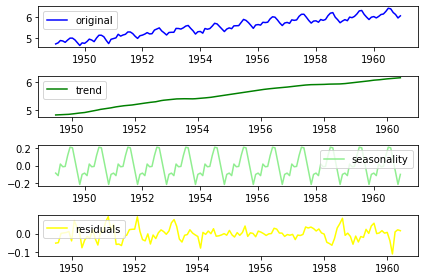

In [30]:
decompose_result = decompose_and_plot(dataset_log, 'Passengers')

In [31]:
#check stationarty for decomposed residual 
dataset_log_residual = decompose_result['residual']
dataset_log_residual = pd.DataFrame(dataset_log_residual)
dataset_log_residual.columns = ['Passengers']

In [32]:
dataset_log_residual.head(20)

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,-0.050884
1949-08-01,-0.048415
1949-09-01,0.001223


In [33]:
dataset_log_residual.dropna(inplace=True)

STATIONARY TEST RESULT

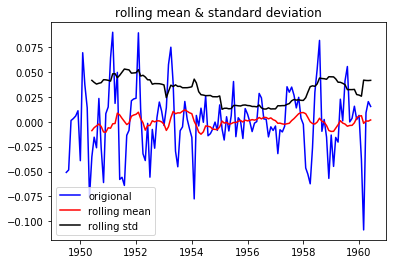

dicky fullter test result:


test statistic          -6.332387e+00
p-value                  2.885059e-08
#lags used               9.000000e+00
number of observation    1.220000e+02
critical value (1%)     -3.485122e+00
critical value (5%)     -2.885538e+00
critical value (10%)    -2.579569e+00
dtype: float64

In [34]:
test_stationary(dataset_log_residual, 'Passengers')

C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


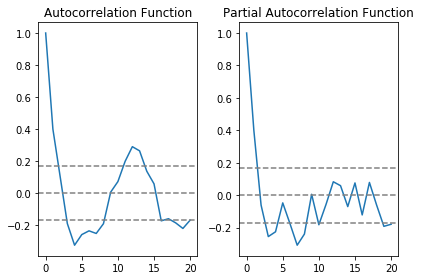

In [35]:
#correlationa and auto correlation
plot_acf_and_pacf(dataset_log_residual)

*********rss************ :  [1.50230337]


C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


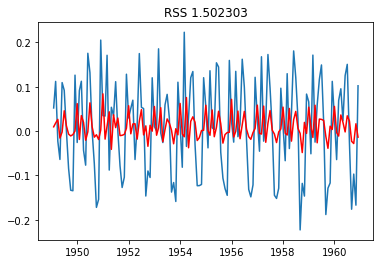

In [74]:
#TEST Models
# 1. TEST AR Model
model_ar = create_arima_and_plot_result(dataset_log, dataset_log_shift_difference, 2, 1, 0 )

*********rss************ :  [1.47214014]


C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


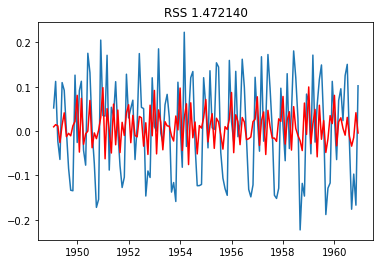

In [75]:
#Test MA Model
model_ma = create_arima_and_plot_result(dataset_log, dataset_log_shift_difference, 0, 1, 2 )
#create_arima_and_plot_result(dataset_log_residual, 0,1,2)

C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\henci\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


*********rss************ :  [1.029152]


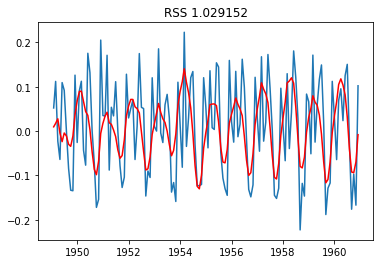

In [77]:
#Test combined - ARIMA Model
model_arima = create_arima_and_plot_result(dataset_log, dataset_log_shift_difference, 2, 1, 2 )

In [83]:
#convert to original scale
prediction_arima = pd.Series(model_arima.fittedvalues, copy=True)    
print(prediction_arima.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [84]:
#cummulative sum 
prediction_arima_cumsum = prediction_arima.cumsum()
print(prediction_arima_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [124]:
#add the result to base number
temp = np.empty(len(dataset_log))
temp.fill(float(dataset_log.values[0]))
prediction_arima_log = pd.Series(temp, index=dataset_log.index)
prediction_arima_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [126]:
prediction_arima_log_result = prediction_arima_log.add(prediction_arima_cumsum,fill_value=0)
prediction_arima_log_result.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'rmse : 1986.2730')

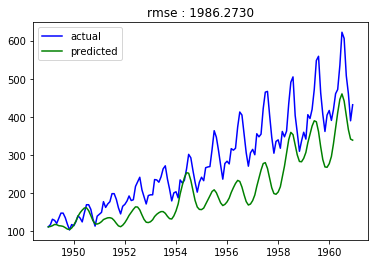

In [165]:
#plot the difference
prediction_arima_log_exp = np.exp(prediction_arima_log_result)
plt.plot(dataset, color='blue', label='actual')
plt.plot(prediction_arima_log_exp, color='green', label='predicted')
rmse = np.sqrt(np.sum(((prediction_arima_log_exp.values - (dataset.values.astype(np.float))) ** 2) / len(dataset)))
plt.legend(loc='best')
plt.title('rmse : %.4f'%rmse)

1986.2729760960037

In [150]:
dataset.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [151]:
prediction_arima_log_exp.head()

Month
1949-01-01    112.000000
1949-02-01    113.078123
1949-03-01    115.073418
1949-04-01    118.301998
1949-05-01    117.768377
dtype: float64